In [ ]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl_rebase'
DATA_DIR = f'{ROOT_DIR}/data/Synthetic'

In [1]:
import pandas as pd
import numpy as np
import sympy as sym
from sklearn.preprocessing import normalize
import ot
import sys
sys.path.append(f'{ROOT_DIR}/code/helper/')
sys.path.append(f'{ROOT_DIR}/code/Synthetic/')
import OTCost as ot
import dataCreator as dc
import importlib
importlib.reload(ot)
importlib.reload(dc)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def loadData(name, size = 500):
    ##load data
    X = pd.read_csv(f'{DATA_DIR}/{name}.csv', sep = ' ', names = [i for i in range(13)])
    ##merge
    X = X.sample(frac = 1)
    X = X.iloc[:size]
    ##get X and label
    y = X.iloc[:,-1]
    X = X.iloc[:,:-1]
    return X,y

In [3]:
def prepData(data, index_i, index_j):

    ## transpose datasets
    X1 = data['1'].T
    X2 = data['2'].T

    ##select the correct indeices for the labels
    X1 = X1[:, index_i]
    X2 = X2[:, index_j]
    ## normalise vecotrs on l2 norm

    X1 = normalize(X1, norm = 'l2', axis = 0)
    X2 = normalize(X2, norm = 'l2', axis = 0)
    n = X1.shape[0]
    ## select large prime
    p = sym.nextprime(n)

    return X1, X2, n, p

def generatorMatrix(k,p):
    V = np.vander(np.arange(1,k//2 + 1), p - 1, increasing = True) % p
    G = np.array(sym.Matrix(V).rref(pivots = False), dtype = float)
    #G = rref(V, tol = 1.0e-12)
    remaining_cols = G.shape[1] - (p-1-G.shape[1])
    G_ = G[:,:remaining_cols]
    
    ##Break down matrix G and G^-1 into A,B,C,D
    A = G_.T
    D = np.hstack((G_[:,k//2:].T, G_[:,:k//2] - 2* G_[:,:k//2]))
    ##B1 = I, B2 = -I + A2
    B = np.vstack((np.eye(k//2), np.eye(k//2)- 2*np.eye(k//2) + A[k//2:]))
    ##C1 = I-A2, C2 = I
    C =  np.hstack((np.eye(k//2) - A[k//2:], np.eye(k//2)))
    return A, B, C, D

def multipartyComp(X, M):
    X1, X2 = X
    A, B, C, D = M

    ##party a
    X1_a = np.dot(X1.T, A)
    X1_b = np.dot(X1.T, B)

    ##party b
    X2_a = np.dot(C, X2)
    X2_b = np.dot(D, X2)

    ##join
    V1 = np.dot(X1_a, X2_a)
    V2 = np.dot(X1_b, X2_b)

    return V1, V2


def privateDotproduct(data, index_i, index_j):
    X1, X2, n, p = prepData(data, index_i, index_j)
    A, B, C, D = generatorMatrix(n, p)
    X, M = (X1, X2), (A, B, C, D)
    V1, V2 = multipartyComp(X, M)
    dot_product = V1 + V2
    return 1 - dot_product


## optimal transport cost

In [4]:
def costOpenPrivate(DATASET, data, label):
    ## calculate cost
    Synthetic_OTCost_label = ot.OTCost(DATASET, data, label)
    cost = Synthetic_OTCost_label.calculate_ot_cost()
    cost = float("{:.3f}".format(float(cost)))
    
    ##calculate cost private date
    Synthetic_OTCost_label = ot.OTCost(DATASET, data, label, private = True)
    cost = Synthetic_OTCost_label.calculate_ot_cost()
    cost_p = float("{:.3f}".format(float(cost)))
    return [cost, cost_p]

In [5]:
def runComparison(private = True):
    fracs = np.arange(0,1.1, 0.1)
    results = {}
    nfeatures = 12

    
    for frac in fracs:
        ##load data
        data, label = dc.non_iid_creator(frac)
        ##store results
        results[frac] = costOpenPrivate(data, label, private)

    noises = [(250e-3, 250e-3), (10e-3, 10e-3), (50e-3, 50e-3)]
    switches = [60, 40, 0]
    a0s = [np.array([1,1,1,1,1,1,1,1,1,1,-1,-1]).reshape(1,-1) / np.sqrt(nfeatures),
           np.array([1,1,1,1,1,1,1,1,1,1,1,1]).reshape(1,-1) / np.sqrt(nfeatures),
           np.array([1,1,1,1,1,1,1,1,1,1,1,1]).reshape(1,-1) / np.sqrt(nfeatures)]
    a1s = [np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1]).reshape(1,-1) / np.sqrt(nfeatures),
           np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]).reshape(1,-1) / np.sqrt(nfeatures),
           np.array([-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]).reshape(1,-1) / np.sqrt(nfeatures)]
    sims = [60, 80,100]
    for noise, switch, a0, a1, sim in zip(noises, switches, a0s, a1s, sims): 
        data, label = dc.deterministicDatasetCreator(a0, a1, nfeatures, noise, switch = switch, size = 200)
        results[sim] = costOpenPrivate(data, label,  private)

    df = pd.DataFrame.from_dict(results, orient = 'index', columns = ['open', 'private'])
    return df.astype('float')

In [6]:
importlib.reload(ot)
df_private = runComparison(private = True)

cost: 0.0237937992
cost: 0.0237937992
cost: 0.0532834774
cost: 0.0532834774
cost: 0.0943967601
cost: 0.0943967601
cost: 0.1338251470
cost: 0.1338251470
cost: 0.1780615169
cost: 0.1780615169
cost: 0.2105049428
cost: 0.2105049428
cost: 0.2769353372
cost: 0.2769353372
cost: 0.3300024419
cost: 0.3300024419
cost: 0.3746066560
cost: 0.3746066560
cost: 0.4421324859
cost: 0.4421324859
cost: 0.4983929824
cost: 0.4983929824
cost: 0.3283741679
cost: 0.3283741679
cost: 0.4050899158
cost: 0.4050899158
cost: 0.0131792736
cost: 0.0131792736


In [7]:
save_path = f'{ROOT_DIR}/results/privacy/'
name = 'accuracy_smpc'
df_private.to_csv(f'{save_path}{name}.csv')

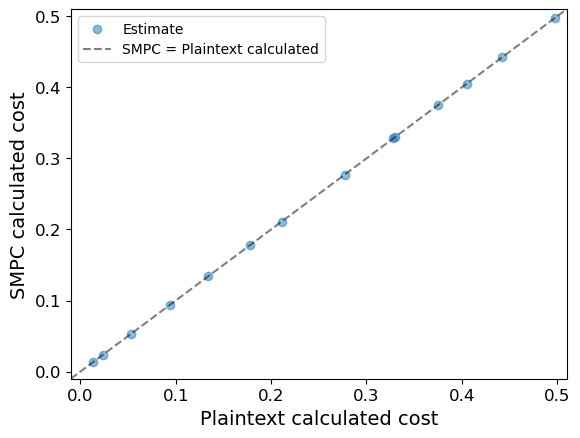

In [10]:
fig, ax = plt.subplots()
ax.scatter(x = df_private['open'], y = df_private['private'], label = 'Estimate',alpha = 0.5)
ax.plot([0,1],[0,1], transform=ax.transAxes, color = 'black', linestyle = '--', alpha = 0.5, label = 'SMPC = Plaintext calculated')
plt.ylim((-0.01,0.51))
plt.xlim(-0.01,0.51)
plt.ylabel('SMPC calculated cost', fontsize = 14)
plt.xlabel('Plaintext calculated cost', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend()
plt.savefig(f'{save_path}/{name}.pdf')
